# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-3
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

Epoch 1/200, Iteration 1/25, Loss: 0.1749
Epoch 1/200, Iteration 2/25, Loss: 2.6672
Epoch 1/200, Iteration 3/25, Loss: 3.9174
Epoch 1/200, Iteration 4/25, Loss: 2.8517
Epoch 1/200, Iteration 5/25, Loss: 1.0716
Epoch 1/200, Iteration 6/25, Loss: 0.5583
Epoch 1/200, Iteration 7/25, Loss: 0.8913
Epoch 1/200, Iteration 8/25, Loss: 0.5740
Epoch 1/200, Iteration 9/25, Loss: 0.1226
Epoch 1/200, Iteration 10/25, Loss: 0.4813
Epoch 1/200, Iteration 11/25, Loss: 0.3997
Epoch 1/200, Iteration 12/25, Loss: 0.1206
Epoch 1/200, Iteration 13/25, Loss: 0.3091
Epoch 1/200, Iteration 14/25, Loss: 0.1289
Epoch 1/200, Iteration 15/25, Loss: 0.3052
Epoch 1/200, Iteration 16/25, Loss: 0.3622
Epoch 1/200, Iteration 17/25, Loss: 0.1206
Epoch 1/200, Iteration 18/25, Loss: 0.3426
Epoch 1/200, Iteration 19/25, Loss: 0.4026
Epoch 1/200, Iteration 20/25, Loss: 0.2401
Epoch 1/200, Iteration 21/25, Loss: 0.2091
Epoch 1/200, Iteration 22/25, Loss: 0.3498
Epoch 1/200, Iteration 23/25, Loss: 0.2445
Epoch 1/200, Iterati

Epoch 8/200, Iteration 12/25, Loss: 0.0810
Epoch 8/200, Iteration 13/25, Loss: 0.1421
Epoch 8/200, Iteration 14/25, Loss: 0.0902
Epoch 8/200, Iteration 15/25, Loss: 0.1133
Epoch 8/200, Iteration 16/25, Loss: 0.0867
Epoch 8/200, Iteration 17/25, Loss: 0.0985
Epoch 8/200, Iteration 18/25, Loss: 0.1228
Epoch 8/200, Iteration 19/25, Loss: 0.0513
Epoch 8/200, Iteration 20/25, Loss: 0.1579
Epoch 8/200, Iteration 21/25, Loss: 0.0877
Epoch 8/200, Iteration 22/25, Loss: 0.1163
Epoch 8/200, Iteration 23/25, Loss: 0.0948
Epoch 8/200, Iteration 24/25, Loss: 0.0693
Epoch 8/200, Iteration 25/25, Loss: 0.1427
Train Error: 
 Accuracy: 80.75%, Avg loss: 0.109960, MRE: 9.317217 

Test Error: 
 Accuracy: 78.5%, Avg loss: 0.102193, MRE: 19.492512 

Epoch 9/200, Iteration 1/25, Loss: 0.1350
Epoch 9/200, Iteration 2/25, Loss: 0.1272
Epoch 9/200, Iteration 3/25, Loss: 0.0823
Epoch 9/200, Iteration 4/25, Loss: 0.1226
Epoch 9/200, Iteration 5/25, Loss: 0.0860
Epoch 9/200, Iteration 6/25, Loss: 0.1217
Epoch 9/2

Epoch 15/200, Iteration 13/25, Loss: 0.1191
Epoch 15/200, Iteration 14/25, Loss: 0.1243
Epoch 15/200, Iteration 15/25, Loss: 0.1115
Epoch 15/200, Iteration 16/25, Loss: 0.0979
Epoch 15/200, Iteration 17/25, Loss: 0.1573
Epoch 15/200, Iteration 18/25, Loss: 0.1019
Epoch 15/200, Iteration 19/25, Loss: 0.1363
Epoch 15/200, Iteration 20/25, Loss: 0.0962
Epoch 15/200, Iteration 21/25, Loss: 0.1487
Epoch 15/200, Iteration 22/25, Loss: 0.0875
Epoch 15/200, Iteration 23/25, Loss: 0.0832
Epoch 15/200, Iteration 24/25, Loss: 0.0864
Epoch 15/200, Iteration 25/25, Loss: 0.0959
Train Error: 
 Accuracy: 62.0%, Avg loss: 0.080684, MRE: 4.809693 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.081702, MRE: 10.010562 

Epoch 16/200, Iteration 1/25, Loss: 0.0811
Epoch 16/200, Iteration 2/25, Loss: 0.0808
Epoch 16/200, Iteration 3/25, Loss: 0.0636
Epoch 16/200, Iteration 4/25, Loss: 0.0749
Epoch 16/200, Iteration 5/25, Loss: 0.0733
Epoch 16/200, Iteration 6/25, Loss: 0.0772
Epoch 16/200, Iteration 7/25, Loss

Train Error: 
 Accuracy: 60.75%, Avg loss: 0.079821, MRE: 4.502022 

Test Error: 
 Accuracy: 55.0%, Avg loss: 0.081978, MRE: 9.355484 

Epoch 23/200, Iteration 1/25, Loss: 0.0908
Epoch 23/200, Iteration 2/25, Loss: 0.0808
Epoch 23/200, Iteration 3/25, Loss: 0.0794
Epoch 23/200, Iteration 4/25, Loss: 0.0758
Epoch 23/200, Iteration 5/25, Loss: 0.0847
Epoch 23/200, Iteration 6/25, Loss: 0.0826
Epoch 23/200, Iteration 7/25, Loss: 0.0913
Epoch 23/200, Iteration 8/25, Loss: 0.0608
Epoch 23/200, Iteration 9/25, Loss: 0.0892
Epoch 23/200, Iteration 10/25, Loss: 0.0831
Epoch 23/200, Iteration 11/25, Loss: 0.0705
Epoch 23/200, Iteration 12/25, Loss: 0.0893
Epoch 23/200, Iteration 13/25, Loss: 0.0831
Epoch 23/200, Iteration 14/25, Loss: 0.0824
Epoch 23/200, Iteration 15/25, Loss: 0.0689
Epoch 23/200, Iteration 16/25, Loss: 0.0785
Epoch 23/200, Iteration 17/25, Loss: 0.0741
Epoch 23/200, Iteration 18/25, Loss: 0.0853
Epoch 23/200, Iteration 19/25, Loss: 0.0742
Epoch 23/200, Iteration 20/25, Loss: 

Epoch 30/200, Iteration 8/25, Loss: 0.0965
Epoch 30/200, Iteration 9/25, Loss: 0.0841
Epoch 30/200, Iteration 10/25, Loss: 0.1015
Epoch 30/200, Iteration 11/25, Loss: 0.0736
Epoch 30/200, Iteration 12/25, Loss: 0.0803
Epoch 30/200, Iteration 13/25, Loss: 0.0717
Epoch 30/200, Iteration 14/25, Loss: 0.0864
Epoch 30/200, Iteration 15/25, Loss: 0.0831
Epoch 30/200, Iteration 16/25, Loss: 0.0896
Epoch 30/200, Iteration 17/25, Loss: 0.0829
Epoch 30/200, Iteration 18/25, Loss: 0.0912
Epoch 30/200, Iteration 19/25, Loss: 0.0734
Epoch 30/200, Iteration 20/25, Loss: 0.0837
Epoch 30/200, Iteration 21/25, Loss: 0.0715
Epoch 30/200, Iteration 22/25, Loss: 0.0772
Epoch 30/200, Iteration 23/25, Loss: 0.0807
Epoch 30/200, Iteration 24/25, Loss: 0.0805
Epoch 30/200, Iteration 25/25, Loss: 0.0788
Train Error: 
 Accuracy: 56.5%, Avg loss: 0.078449, MRE: 3.735615 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083213, MRE: 7.706044 

Epoch 31/200, Iteration 1/25, Loss: 0.0797
Epoch 31/200, Iteration 2/25, Lo

Epoch 37/200, Iteration 16/25, Loss: 0.0880
Epoch 37/200, Iteration 17/25, Loss: 0.0786
Epoch 37/200, Iteration 18/25, Loss: 0.0725
Epoch 37/200, Iteration 19/25, Loss: 0.0659
Epoch 37/200, Iteration 20/25, Loss: 0.0802
Epoch 37/200, Iteration 21/25, Loss: 0.1016
Epoch 37/200, Iteration 22/25, Loss: 0.0832
Epoch 37/200, Iteration 23/25, Loss: 0.0826
Epoch 37/200, Iteration 24/25, Loss: 0.0791
Epoch 37/200, Iteration 25/25, Loss: 0.0763
Train Error: 
 Accuracy: 45.12%, Avg loss: 0.080508, MRE: 2.305607 

Test Error: 
 Accuracy: 40.0%, Avg loss: 0.088559, MRE: 4.494358 

Epoch 38/200, Iteration 1/25, Loss: 0.0794
Epoch 38/200, Iteration 2/25, Loss: 0.1019
Epoch 38/200, Iteration 3/25, Loss: 0.0689
Epoch 38/200, Iteration 4/25, Loss: 0.0821
Epoch 38/200, Iteration 5/25, Loss: 0.0968
Epoch 38/200, Iteration 6/25, Loss: 0.0615
Epoch 38/200, Iteration 7/25, Loss: 0.0904
Epoch 38/200, Iteration 8/25, Loss: 0.0711
Epoch 38/200, Iteration 9/25, Loss: 0.0918
Epoch 38/200, Iteration 10/25, Loss: 

Train Error: 
 Accuracy: 56.12%, Avg loss: 0.078393, MRE: 3.642625 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083379, MRE: 7.502202 

Epoch 45/200, Iteration 1/25, Loss: 0.0961
Epoch 45/200, Iteration 2/25, Loss: 0.0799
Epoch 45/200, Iteration 3/25, Loss: 0.0783
Epoch 45/200, Iteration 4/25, Loss: 0.0755
Epoch 45/200, Iteration 5/25, Loss: 0.0929
Epoch 45/200, Iteration 6/25, Loss: 0.0587
Epoch 45/200, Iteration 7/25, Loss: 0.0917
Epoch 45/200, Iteration 8/25, Loss: 0.0843
Epoch 45/200, Iteration 9/25, Loss: 0.1032
Epoch 45/200, Iteration 10/25, Loss: 0.0700
Epoch 45/200, Iteration 11/25, Loss: 0.0697
Epoch 45/200, Iteration 12/25, Loss: 0.0682
Epoch 45/200, Iteration 13/25, Loss: 0.0727
Epoch 45/200, Iteration 14/25, Loss: 0.0751
Epoch 45/200, Iteration 15/25, Loss: 0.0766
Epoch 45/200, Iteration 16/25, Loss: 0.0583
Epoch 45/200, Iteration 17/25, Loss: 0.0873
Epoch 45/200, Iteration 18/25, Loss: 0.0748
Epoch 45/200, Iteration 19/25, Loss: 0.0636
Epoch 45/200, Iteration 20/25, Loss: 

Epoch 52/200, Iteration 15/25, Loss: 0.0906
Epoch 52/200, Iteration 16/25, Loss: 0.0816
Epoch 52/200, Iteration 17/25, Loss: 0.0708
Epoch 52/200, Iteration 18/25, Loss: 0.0906
Epoch 52/200, Iteration 19/25, Loss: 0.0807
Epoch 52/200, Iteration 20/25, Loss: 0.0766
Epoch 52/200, Iteration 21/25, Loss: 0.0615
Epoch 52/200, Iteration 22/25, Loss: 0.0762
Epoch 52/200, Iteration 23/25, Loss: 0.0613
Epoch 52/200, Iteration 24/25, Loss: 0.0755
Epoch 52/200, Iteration 25/25, Loss: 0.0830
Train Error: 
 Accuracy: 55.25%, Avg loss: 0.078364, MRE: 3.551270 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083557, MRE: 7.301203 

Epoch 53/200, Iteration 1/25, Loss: 0.0833
Epoch 53/200, Iteration 2/25, Loss: 0.0720
Epoch 53/200, Iteration 3/25, Loss: 0.0665
Epoch 53/200, Iteration 4/25, Loss: 0.0746
Epoch 53/200, Iteration 5/25, Loss: 0.0713
Epoch 53/200, Iteration 6/25, Loss: 0.0705
Epoch 53/200, Iteration 7/25, Loss: 0.0795
Epoch 53/200, Iteration 8/25, Loss: 0.0703
Epoch 53/200, Iteration 9/25, Loss: 

Epoch 60/200, Iteration 13/25, Loss: 0.0693
Epoch 60/200, Iteration 14/25, Loss: 0.0858
Epoch 60/200, Iteration 15/25, Loss: 0.0783
Epoch 60/200, Iteration 16/25, Loss: 0.0789
Epoch 60/200, Iteration 17/25, Loss: 0.0698
Epoch 60/200, Iteration 18/25, Loss: 0.0818
Epoch 60/200, Iteration 19/25, Loss: 0.0700
Epoch 60/200, Iteration 20/25, Loss: 0.0771
Epoch 60/200, Iteration 21/25, Loss: 0.0767
Epoch 60/200, Iteration 22/25, Loss: 0.0742
Epoch 60/200, Iteration 23/25, Loss: 0.0726
Epoch 60/200, Iteration 24/25, Loss: 0.0829
Epoch 60/200, Iteration 25/25, Loss: 0.0765
Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.515463 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083639, MRE: 7.222292 

Epoch 61/200, Iteration 1/25, Loss: 0.0683
Epoch 61/200, Iteration 2/25, Loss: 0.0805
Epoch 61/200, Iteration 3/25, Loss: 0.0825
Epoch 61/200, Iteration 4/25, Loss: 0.0860
Epoch 61/200, Iteration 5/25, Loss: 0.0810
Epoch 61/200, Iteration 6/25, Loss: 0.0520
Epoch 61/200, Iteration 7/25, Loss:

Epoch 67/200, Iteration 12/25, Loss: 0.0794
Epoch 67/200, Iteration 13/25, Loss: 0.0666
Epoch 67/200, Iteration 14/25, Loss: 0.0728
Epoch 67/200, Iteration 15/25, Loss: 0.0835
Epoch 67/200, Iteration 16/25, Loss: 0.0717
Epoch 67/200, Iteration 17/25, Loss: 0.0662
Epoch 67/200, Iteration 18/25, Loss: 0.0879
Epoch 67/200, Iteration 19/25, Loss: 0.0720
Epoch 67/200, Iteration 20/25, Loss: 0.0860
Epoch 67/200, Iteration 21/25, Loss: 0.0916
Epoch 67/200, Iteration 22/25, Loss: 0.0744
Epoch 67/200, Iteration 23/25, Loss: 0.0816
Epoch 67/200, Iteration 24/25, Loss: 0.0887
Epoch 67/200, Iteration 25/25, Loss: 0.0931
Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.506180 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083660, MRE: 7.201803 

Epoch 68/200, Iteration 1/25, Loss: 0.0687
Epoch 68/200, Iteration 2/25, Loss: 0.0786
Epoch 68/200, Iteration 3/25, Loss: 0.0837
Epoch 68/200, Iteration 4/25, Loss: 0.0739
Epoch 68/200, Iteration 5/25, Loss: 0.0862
Epoch 68/200, Iteration 6/25, Loss

Epoch 74/200, Iteration 12/25, Loss: 0.0691
Epoch 74/200, Iteration 13/25, Loss: 0.0950
Epoch 74/200, Iteration 14/25, Loss: 0.0691
Epoch 74/200, Iteration 15/25, Loss: 0.0600
Epoch 74/200, Iteration 16/25, Loss: 0.0895
Epoch 74/200, Iteration 17/25, Loss: 0.0874
Epoch 74/200, Iteration 18/25, Loss: 0.0775
Epoch 74/200, Iteration 19/25, Loss: 0.0823
Epoch 74/200, Iteration 20/25, Loss: 0.0808
Epoch 74/200, Iteration 21/25, Loss: 0.1033
Epoch 74/200, Iteration 22/25, Loss: 0.0867
Epoch 74/200, Iteration 23/25, Loss: 0.0650
Epoch 74/200, Iteration 24/25, Loss: 0.0572
Epoch 74/200, Iteration 25/25, Loss: 0.0632
Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.507664 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083656, MRE: 7.205079 

Epoch 75/200, Iteration 1/25, Loss: 0.0749
Epoch 75/200, Iteration 2/25, Loss: 0.0852
Epoch 75/200, Iteration 3/25, Loss: 0.0813
Epoch 75/200, Iteration 4/25, Loss: 0.0762
Epoch 75/200, Iteration 5/25, Loss: 0.1057
Epoch 75/200, Iteration 6/25, Loss

Epoch 82/200, Iteration 18/25, Loss: 0.0956
Epoch 82/200, Iteration 19/25, Loss: 0.0668
Epoch 82/200, Iteration 20/25, Loss: 0.0880
Epoch 82/200, Iteration 21/25, Loss: 0.0747
Epoch 82/200, Iteration 22/25, Loss: 0.0578
Epoch 82/200, Iteration 23/25, Loss: 0.0739
Epoch 82/200, Iteration 24/25, Loss: 0.0881
Epoch 82/200, Iteration 25/25, Loss: 0.0770
Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508121 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083655, MRE: 7.206089 

Epoch 83/200, Iteration 1/25, Loss: 0.0853
Epoch 83/200, Iteration 2/25, Loss: 0.0682
Epoch 83/200, Iteration 3/25, Loss: 0.0886
Epoch 83/200, Iteration 4/25, Loss: 0.0894
Epoch 83/200, Iteration 5/25, Loss: 0.0640
Epoch 83/200, Iteration 6/25, Loss: 0.0864
Epoch 83/200, Iteration 7/25, Loss: 0.0791
Epoch 83/200, Iteration 8/25, Loss: 0.0850
Epoch 83/200, Iteration 9/25, Loss: 0.0742
Epoch 83/200, Iteration 10/25, Loss: 0.0823
Epoch 83/200, Iteration 11/25, Loss: 0.0610
Epoch 83/200, Iteration 12/25, Loss: 0

Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508145 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083655, MRE: 7.206140 

Epoch 90/200, Iteration 1/25, Loss: 0.0718
Epoch 90/200, Iteration 2/25, Loss: 0.0803
Epoch 90/200, Iteration 3/25, Loss: 0.0819
Epoch 90/200, Iteration 4/25, Loss: 0.0751
Epoch 90/200, Iteration 5/25, Loss: 0.0846
Epoch 90/200, Iteration 6/25, Loss: 0.0818
Epoch 90/200, Iteration 7/25, Loss: 0.0771
Epoch 90/200, Iteration 8/25, Loss: 0.0668
Epoch 90/200, Iteration 9/25, Loss: 0.0917
Epoch 90/200, Iteration 10/25, Loss: 0.0796
Epoch 90/200, Iteration 11/25, Loss: 0.0943
Epoch 90/200, Iteration 12/25, Loss: 0.0904
Epoch 90/200, Iteration 13/25, Loss: 0.0886
Epoch 90/200, Iteration 14/25, Loss: 0.0754
Epoch 90/200, Iteration 15/25, Loss: 0.0803
Epoch 90/200, Iteration 16/25, Loss: 0.0646
Epoch 90/200, Iteration 17/25, Loss: 0.0619
Epoch 90/200, Iteration 18/25, Loss: 0.0581
Epoch 90/200, Iteration 19/25, Loss: 0.0825
Epoch 90/200, Iteration 20/25, Loss: 0

Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508246 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083655, MRE: 7.206365 

Epoch 97/200, Iteration 1/25, Loss: 0.0897
Epoch 97/200, Iteration 2/25, Loss: 0.0673
Epoch 97/200, Iteration 3/25, Loss: 0.0780
Epoch 97/200, Iteration 4/25, Loss: 0.1040
Epoch 97/200, Iteration 5/25, Loss: 0.0825
Epoch 97/200, Iteration 6/25, Loss: 0.0925
Epoch 97/200, Iteration 7/25, Loss: 0.0901
Epoch 97/200, Iteration 8/25, Loss: 0.0878
Epoch 97/200, Iteration 9/25, Loss: 0.0811
Epoch 97/200, Iteration 10/25, Loss: 0.0848
Epoch 97/200, Iteration 11/25, Loss: 0.0690
Epoch 97/200, Iteration 12/25, Loss: 0.0638
Epoch 97/200, Iteration 13/25, Loss: 0.0815
Epoch 97/200, Iteration 14/25, Loss: 0.0618
Epoch 97/200, Iteration 15/25, Loss: 0.0684
Epoch 97/200, Iteration 16/25, Loss: 0.0797
Epoch 97/200, Iteration 17/25, Loss: 0.0565
Epoch 97/200, Iteration 18/25, Loss: 0.0658
Epoch 97/200, Iteration 19/25, Loss: 0.0702
Epoch 97/200, Iteration 20/25, Loss: 0

Epoch 103/200, Iteration 25/25, Loss: 0.0865
Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508138 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083655, MRE: 7.206126 

Epoch 104/200, Iteration 1/25, Loss: 0.0591
Epoch 104/200, Iteration 2/25, Loss: 0.0937
Epoch 104/200, Iteration 3/25, Loss: 0.0803
Epoch 104/200, Iteration 4/25, Loss: 0.0999
Epoch 104/200, Iteration 5/25, Loss: 0.0738
Epoch 104/200, Iteration 6/25, Loss: 0.0950
Epoch 104/200, Iteration 7/25, Loss: 0.0999
Epoch 104/200, Iteration 8/25, Loss: 0.0664
Epoch 104/200, Iteration 9/25, Loss: 0.0804
Epoch 104/200, Iteration 10/25, Loss: 0.0719
Epoch 104/200, Iteration 11/25, Loss: 0.0990
Epoch 104/200, Iteration 12/25, Loss: 0.0875
Epoch 104/200, Iteration 13/25, Loss: 0.0902
Epoch 104/200, Iteration 14/25, Loss: 0.0844
Epoch 104/200, Iteration 15/25, Loss: 0.0758
Epoch 104/200, Iteration 16/25, Loss: 0.0724
Epoch 104/200, Iteration 17/25, Loss: 0.0585
Epoch 104/200, Iteration 18/25, Loss: 0.0618
Epoch 104/200, Iter

Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508125 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083655, MRE: 7.206096 

Epoch 111/200, Iteration 1/25, Loss: 0.0755
Epoch 111/200, Iteration 2/25, Loss: 0.0751
Epoch 111/200, Iteration 3/25, Loss: 0.0741
Epoch 111/200, Iteration 4/25, Loss: 0.0839
Epoch 111/200, Iteration 5/25, Loss: 0.0813
Epoch 111/200, Iteration 6/25, Loss: 0.0682
Epoch 111/200, Iteration 7/25, Loss: 0.0868
Epoch 111/200, Iteration 8/25, Loss: 0.0877
Epoch 111/200, Iteration 9/25, Loss: 0.0855
Epoch 111/200, Iteration 10/25, Loss: 0.0770
Epoch 111/200, Iteration 11/25, Loss: 0.1111
Epoch 111/200, Iteration 12/25, Loss: 0.0677
Epoch 111/200, Iteration 13/25, Loss: 0.0752
Epoch 111/200, Iteration 14/25, Loss: 0.0903
Epoch 111/200, Iteration 15/25, Loss: 0.0838
Epoch 111/200, Iteration 16/25, Loss: 0.0855
Epoch 111/200, Iteration 17/25, Loss: 0.0550
Epoch 111/200, Iteration 18/25, Loss: 0.0638
Epoch 111/200, Iteration 19/25, Loss: 0.0966
Epoch 111/200, Iter

Epoch 118/200, Iteration 15/25, Loss: 0.0831
Epoch 118/200, Iteration 16/25, Loss: 0.0734
Epoch 118/200, Iteration 17/25, Loss: 0.0678
Epoch 118/200, Iteration 18/25, Loss: 0.0596
Epoch 118/200, Iteration 19/25, Loss: 0.0890
Epoch 118/200, Iteration 20/25, Loss: 0.0868
Epoch 118/200, Iteration 21/25, Loss: 0.0846
Epoch 118/200, Iteration 22/25, Loss: 0.0887
Epoch 118/200, Iteration 23/25, Loss: 0.0653
Epoch 118/200, Iteration 24/25, Loss: 0.0900
Epoch 118/200, Iteration 25/25, Loss: 0.0787
Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508002 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083656, MRE: 7.205825 

Epoch 119/200, Iteration 1/25, Loss: 0.0798
Epoch 119/200, Iteration 2/25, Loss: 0.0730
Epoch 119/200, Iteration 3/25, Loss: 0.0721
Epoch 119/200, Iteration 4/25, Loss: 0.0943
Epoch 119/200, Iteration 5/25, Loss: 0.0936
Epoch 119/200, Iteration 6/25, Loss: 0.0926
Epoch 119/200, Iteration 7/25, Loss: 0.0582
Epoch 119/200, Iteration 8/25, Loss: 0.0768
Epoch 119/200, Ite

Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508125 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083655, MRE: 7.206097 

Epoch 126/200, Iteration 1/25, Loss: 0.0844
Epoch 126/200, Iteration 2/25, Loss: 0.0725
Epoch 126/200, Iteration 3/25, Loss: 0.0799
Epoch 126/200, Iteration 4/25, Loss: 0.0913
Epoch 126/200, Iteration 5/25, Loss: 0.0809
Epoch 126/200, Iteration 6/25, Loss: 0.0742
Epoch 126/200, Iteration 7/25, Loss: 0.0648
Epoch 126/200, Iteration 8/25, Loss: 0.0834
Epoch 126/200, Iteration 9/25, Loss: 0.0824
Epoch 126/200, Iteration 10/25, Loss: 0.0797
Epoch 126/200, Iteration 11/25, Loss: 0.0817
Epoch 126/200, Iteration 12/25, Loss: 0.0790
Epoch 126/200, Iteration 13/25, Loss: 0.0695
Epoch 126/200, Iteration 14/25, Loss: 0.0880
Epoch 126/200, Iteration 15/25, Loss: 0.0806
Epoch 126/200, Iteration 16/25, Loss: 0.0802
Epoch 126/200, Iteration 17/25, Loss: 0.0879
Epoch 126/200, Iteration 18/25, Loss: 0.0645
Epoch 126/200, Iteration 19/25, Loss: 0.0780
Epoch 126/200, Iter

Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508243 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083655, MRE: 7.206358 

Epoch 133/200, Iteration 1/25, Loss: 0.0874
Epoch 133/200, Iteration 2/25, Loss: 0.0913
Epoch 133/200, Iteration 3/25, Loss: 0.0745
Epoch 133/200, Iteration 4/25, Loss: 0.0838
Epoch 133/200, Iteration 5/25, Loss: 0.0870
Epoch 133/200, Iteration 6/25, Loss: 0.0851
Epoch 133/200, Iteration 7/25, Loss: 0.0767
Epoch 133/200, Iteration 8/25, Loss: 0.0812
Epoch 133/200, Iteration 9/25, Loss: 0.0778
Epoch 133/200, Iteration 10/25, Loss: 0.0792
Epoch 133/200, Iteration 11/25, Loss: 0.0739
Epoch 133/200, Iteration 12/25, Loss: 0.0679
Epoch 133/200, Iteration 13/25, Loss: 0.0758
Epoch 133/200, Iteration 14/25, Loss: 0.0704
Epoch 133/200, Iteration 15/25, Loss: 0.0708
Epoch 133/200, Iteration 16/25, Loss: 0.0773
Epoch 133/200, Iteration 17/25, Loss: 0.0885
Epoch 133/200, Iteration 18/25, Loss: 0.0846
Epoch 133/200, Iteration 19/25, Loss: 0.0770
Epoch 133/200, Iter

Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508016 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083656, MRE: 7.205857 

Epoch 140/200, Iteration 1/25, Loss: 0.0914
Epoch 140/200, Iteration 2/25, Loss: 0.0883
Epoch 140/200, Iteration 3/25, Loss: 0.0787
Epoch 140/200, Iteration 4/25, Loss: 0.0839
Epoch 140/200, Iteration 5/25, Loss: 0.0660
Epoch 140/200, Iteration 6/25, Loss: 0.1013
Epoch 140/200, Iteration 7/25, Loss: 0.0801
Epoch 140/200, Iteration 8/25, Loss: 0.0668
Epoch 140/200, Iteration 9/25, Loss: 0.0890
Epoch 140/200, Iteration 10/25, Loss: 0.0838
Epoch 140/200, Iteration 11/25, Loss: 0.0626
Epoch 140/200, Iteration 12/25, Loss: 0.0722
Epoch 140/200, Iteration 13/25, Loss: 0.0858
Epoch 140/200, Iteration 14/25, Loss: 0.0633
Epoch 140/200, Iteration 15/25, Loss: 0.0856
Epoch 140/200, Iteration 16/25, Loss: 0.0719
Epoch 140/200, Iteration 17/25, Loss: 0.0876
Epoch 140/200, Iteration 18/25, Loss: 0.0739
Epoch 140/200, Iteration 19/25, Loss: 0.0666
Epoch 140/200, Iter

Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.507970 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083656, MRE: 7.205755 

Epoch 147/200, Iteration 1/25, Loss: 0.0912
Epoch 147/200, Iteration 2/25, Loss: 0.0711
Epoch 147/200, Iteration 3/25, Loss: 0.0590
Epoch 147/200, Iteration 4/25, Loss: 0.0747
Epoch 147/200, Iteration 5/25, Loss: 0.0909
Epoch 147/200, Iteration 6/25, Loss: 0.0941
Epoch 147/200, Iteration 7/25, Loss: 0.0960
Epoch 147/200, Iteration 8/25, Loss: 0.0861
Epoch 147/200, Iteration 9/25, Loss: 0.0726
Epoch 147/200, Iteration 10/25, Loss: 0.0725
Epoch 147/200, Iteration 11/25, Loss: 0.0816
Epoch 147/200, Iteration 12/25, Loss: 0.0581
Epoch 147/200, Iteration 13/25, Loss: 0.0950
Epoch 147/200, Iteration 14/25, Loss: 0.0702
Epoch 147/200, Iteration 15/25, Loss: 0.0859
Epoch 147/200, Iteration 16/25, Loss: 0.0758
Epoch 147/200, Iteration 17/25, Loss: 0.0608
Epoch 147/200, Iteration 18/25, Loss: 0.0713
Epoch 147/200, Iteration 19/25, Loss: 0.0452
Epoch 147/200, Iter

Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508230 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083655, MRE: 7.206328 

Epoch 154/200, Iteration 1/25, Loss: 0.0788
Epoch 154/200, Iteration 2/25, Loss: 0.0643
Epoch 154/200, Iteration 3/25, Loss: 0.0963
Epoch 154/200, Iteration 4/25, Loss: 0.0834
Epoch 154/200, Iteration 5/25, Loss: 0.0848
Epoch 154/200, Iteration 6/25, Loss: 0.0882
Epoch 154/200, Iteration 7/25, Loss: 0.0917
Epoch 154/200, Iteration 8/25, Loss: 0.0786
Epoch 154/200, Iteration 9/25, Loss: 0.0987
Epoch 154/200, Iteration 10/25, Loss: 0.0744
Epoch 154/200, Iteration 11/25, Loss: 0.0865
Epoch 154/200, Iteration 12/25, Loss: 0.0701
Epoch 154/200, Iteration 13/25, Loss: 0.0680
Epoch 154/200, Iteration 14/25, Loss: 0.0631
Epoch 154/200, Iteration 15/25, Loss: 0.0808
Epoch 154/200, Iteration 16/25, Loss: 0.0651
Epoch 154/200, Iteration 17/25, Loss: 0.0833
Epoch 154/200, Iteration 18/25, Loss: 0.0716
Epoch 154/200, Iteration 19/25, Loss: 0.0731
Epoch 154/200, Iter

Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508310 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083655, MRE: 7.206505 

Epoch 161/200, Iteration 1/25, Loss: 0.0595
Epoch 161/200, Iteration 2/25, Loss: 0.0793
Epoch 161/200, Iteration 3/25, Loss: 0.0768
Epoch 161/200, Iteration 4/25, Loss: 0.0775
Epoch 161/200, Iteration 5/25, Loss: 0.0804
Epoch 161/200, Iteration 6/25, Loss: 0.0832
Epoch 161/200, Iteration 7/25, Loss: 0.0816
Epoch 161/200, Iteration 8/25, Loss: 0.0746
Epoch 161/200, Iteration 9/25, Loss: 0.0744
Epoch 161/200, Iteration 10/25, Loss: 0.0758
Epoch 161/200, Iteration 11/25, Loss: 0.0695
Epoch 161/200, Iteration 12/25, Loss: 0.0758
Epoch 161/200, Iteration 13/25, Loss: 0.0805
Epoch 161/200, Iteration 14/25, Loss: 0.0916
Epoch 161/200, Iteration 15/25, Loss: 0.0934
Epoch 161/200, Iteration 16/25, Loss: 0.0622
Epoch 161/200, Iteration 17/25, Loss: 0.0753
Epoch 161/200, Iteration 18/25, Loss: 0.0761
Epoch 161/200, Iteration 19/25, Loss: 0.0698
Epoch 161/200, Iter

Epoch 168/200, Iteration 8/25, Loss: 0.0870
Epoch 168/200, Iteration 9/25, Loss: 0.0890
Epoch 168/200, Iteration 10/25, Loss: 0.0747
Epoch 168/200, Iteration 11/25, Loss: 0.0882
Epoch 168/200, Iteration 12/25, Loss: 0.0603
Epoch 168/200, Iteration 13/25, Loss: 0.0874
Epoch 168/200, Iteration 14/25, Loss: 0.0819
Epoch 168/200, Iteration 15/25, Loss: 0.0670
Epoch 168/200, Iteration 16/25, Loss: 0.0790
Epoch 168/200, Iteration 17/25, Loss: 0.0897
Epoch 168/200, Iteration 18/25, Loss: 0.0737
Epoch 168/200, Iteration 19/25, Loss: 0.0838
Epoch 168/200, Iteration 20/25, Loss: 0.0770
Epoch 168/200, Iteration 21/25, Loss: 0.0686
Epoch 168/200, Iteration 22/25, Loss: 0.0727
Epoch 168/200, Iteration 23/25, Loss: 0.0642
Epoch 168/200, Iteration 24/25, Loss: 0.0966
Epoch 168/200, Iteration 25/25, Loss: 0.0833
Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508200 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083655, MRE: 7.206263 

Epoch 169/200, Iteration 1/25, Loss: 0.0764
Epoch 169/200

Epoch 175/200, Iteration 1/25, Loss: 0.0762
Epoch 175/200, Iteration 2/25, Loss: 0.0890
Epoch 175/200, Iteration 3/25, Loss: 0.0781
Epoch 175/200, Iteration 4/25, Loss: 0.0994
Epoch 175/200, Iteration 5/25, Loss: 0.0675
Epoch 175/200, Iteration 6/25, Loss: 0.0699
Epoch 175/200, Iteration 7/25, Loss: 0.0848
Epoch 175/200, Iteration 8/25, Loss: 0.0844
Epoch 175/200, Iteration 9/25, Loss: 0.0645
Epoch 175/200, Iteration 10/25, Loss: 0.0630
Epoch 175/200, Iteration 11/25, Loss: 0.0752
Epoch 175/200, Iteration 12/25, Loss: 0.0786
Epoch 175/200, Iteration 13/25, Loss: 0.0705
Epoch 175/200, Iteration 14/25, Loss: 0.0805
Epoch 175/200, Iteration 15/25, Loss: 0.0734
Epoch 175/200, Iteration 16/25, Loss: 0.0917
Epoch 175/200, Iteration 17/25, Loss: 0.0730
Epoch 175/200, Iteration 18/25, Loss: 0.0805
Epoch 175/200, Iteration 19/25, Loss: 0.0735
Epoch 175/200, Iteration 20/25, Loss: 0.0871
Epoch 175/200, Iteration 21/25, Loss: 0.0931
Epoch 175/200, Iteration 22/25, Loss: 0.0793
Epoch 175/200, Iter

Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508192 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083655, MRE: 7.206246 

Epoch 182/200, Iteration 1/25, Loss: 0.0757
Epoch 182/200, Iteration 2/25, Loss: 0.0919
Epoch 182/200, Iteration 3/25, Loss: 0.0751
Epoch 182/200, Iteration 4/25, Loss: 0.0723
Epoch 182/200, Iteration 5/25, Loss: 0.0656
Epoch 182/200, Iteration 6/25, Loss: 0.0756
Epoch 182/200, Iteration 7/25, Loss: 0.0781
Epoch 182/200, Iteration 8/25, Loss: 0.0764
Epoch 182/200, Iteration 9/25, Loss: 0.0876
Epoch 182/200, Iteration 10/25, Loss: 0.0819
Epoch 182/200, Iteration 11/25, Loss: 0.0869
Epoch 182/200, Iteration 12/25, Loss: 0.0839
Epoch 182/200, Iteration 13/25, Loss: 0.0868
Epoch 182/200, Iteration 14/25, Loss: 0.0933
Epoch 182/200, Iteration 15/25, Loss: 0.0868
Epoch 182/200, Iteration 16/25, Loss: 0.0684
Epoch 182/200, Iteration 17/25, Loss: 0.0677
Epoch 182/200, Iteration 18/25, Loss: 0.0582
Epoch 182/200, Iteration 19/25, Loss: 0.0686
Epoch 182/200, Iter

Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508003 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083656, MRE: 7.205828 

Epoch 189/200, Iteration 1/25, Loss: 0.0652
Epoch 189/200, Iteration 2/25, Loss: 0.0927
Epoch 189/200, Iteration 3/25, Loss: 0.0806
Epoch 189/200, Iteration 4/25, Loss: 0.0552
Epoch 189/200, Iteration 5/25, Loss: 0.0736
Epoch 189/200, Iteration 6/25, Loss: 0.0941
Epoch 189/200, Iteration 7/25, Loss: 0.0846
Epoch 189/200, Iteration 8/25, Loss: 0.0796
Epoch 189/200, Iteration 9/25, Loss: 0.0819
Epoch 189/200, Iteration 10/25, Loss: 0.0842
Epoch 189/200, Iteration 11/25, Loss: 0.0866
Epoch 189/200, Iteration 12/25, Loss: 0.0973
Epoch 189/200, Iteration 13/25, Loss: 0.0624
Epoch 189/200, Iteration 14/25, Loss: 0.0733
Epoch 189/200, Iteration 15/25, Loss: 0.0709
Epoch 189/200, Iteration 16/25, Loss: 0.0786
Epoch 189/200, Iteration 17/25, Loss: 0.0710
Epoch 189/200, Iteration 18/25, Loss: 0.0944
Epoch 189/200, Iteration 19/25, Loss: 0.0811
Epoch 189/200, Iter

Epoch 195/200, Iteration 21/25, Loss: 0.0887
Epoch 195/200, Iteration 22/25, Loss: 0.0926
Epoch 195/200, Iteration 23/25, Loss: 0.0704
Epoch 195/200, Iteration 24/25, Loss: 0.0720
Epoch 195/200, Iteration 25/25, Loss: 0.1018
Train Error: 
 Accuracy: 55.0%, Avg loss: 0.078361, MRE: 3.508176 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.083655, MRE: 7.206209 

Epoch 196/200, Iteration 1/25, Loss: 0.0808
Epoch 196/200, Iteration 2/25, Loss: 0.0895
Epoch 196/200, Iteration 3/25, Loss: 0.0881
Epoch 196/200, Iteration 4/25, Loss: 0.0703
Epoch 196/200, Iteration 5/25, Loss: 0.0760
Epoch 196/200, Iteration 6/25, Loss: 0.0911
Epoch 196/200, Iteration 7/25, Loss: 0.0864
Epoch 196/200, Iteration 8/25, Loss: 0.0744
Epoch 196/200, Iteration 9/25, Loss: 0.0620
Epoch 196/200, Iteration 10/25, Loss: 0.0647
Epoch 196/200, Iteration 11/25, Loss: 0.0681
Epoch 196/200, Iteration 12/25, Loss: 0.0870
Epoch 196/200, Iteration 13/25, Loss: 0.0855
Epoch 196/200, Iteration 14/25, Loss: 0.0779
Epoch 196/200, Iter

#### Plots loss vs Epoch

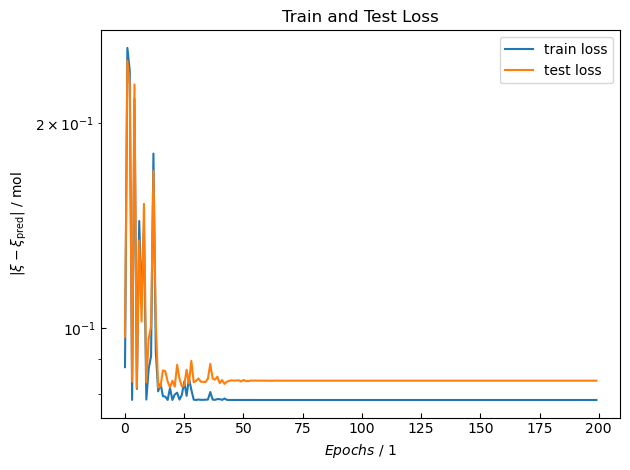

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2 = -0.03271100151112294
Test Dataset: R^2 = -0.06336623943492281
Max Error Training: |xi - xi_pred| = 0.28942910116000564
Max Error Test: |xi - xi_pred| = 0.29531365148605027


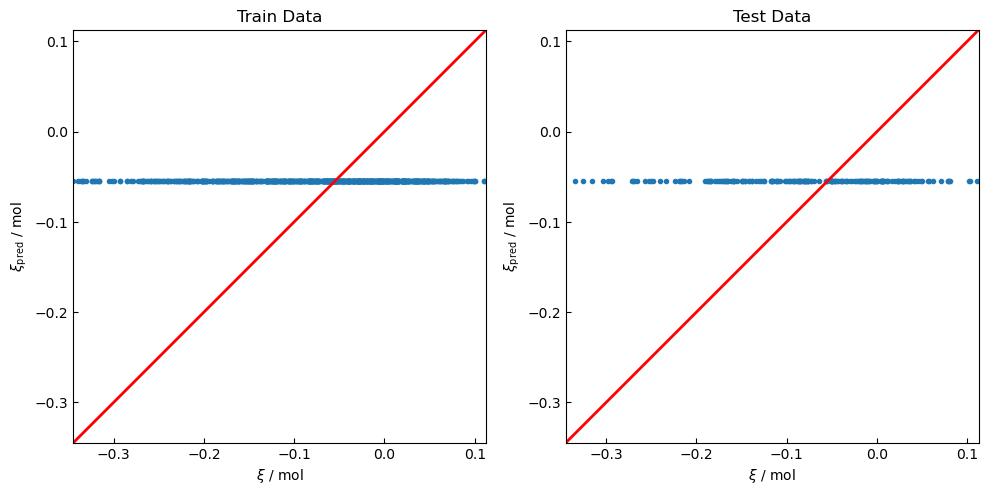

In [11]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

print('Training Dataset: R^2 =', r2(xi_real,xi_pred))
print('Test Dataset: R^2 =', r2(xi_real_test,xi_pred_test))
print('Max Error Training: |xi - xi_pred| =', max_error(xi_real, xi_pred))
print('Max Error Test: |xi - xi_pred| =', max_error(xi_real_test, xi_pred_test))

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

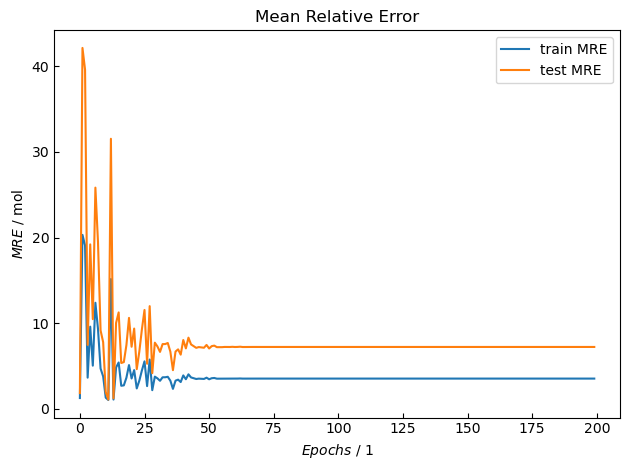

In [12]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

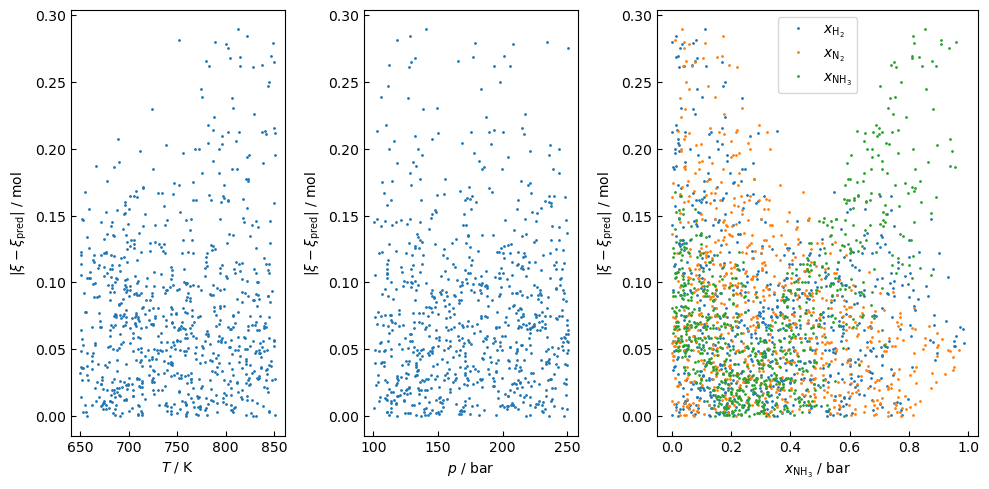

In [13]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

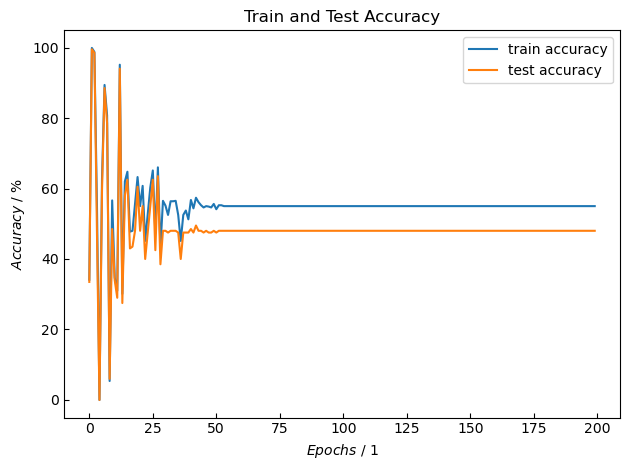

In [14]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [15]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[7.0249e+02, 2.4332e+02, 3.7949e-02, 1.5470e-01, 8.0735e-01],
        [8.0626e+02, 2.3879e+02, 2.4530e-01, 4.5124e-02, 7.0958e-01],
        [7.9248e+02, 1.5939e+02, 3.5904e-03, 6.9877e-01, 2.9764e-01],
        [7.6141e+02, 1.5784e+02, 6.7901e-01, 1.5278e-01, 1.6821e-01],
        [8.2934e+02, 2.1711e+02, 7.7232e-02, 1.7465e-01, 7.4812e-01],
        [8.0762e+02, 2.1445e+02, 4.1963e-01, 5.0222e-01, 7.8152e-02],
        [8.0395e+02, 1.3895e+02, 6.1395e-01, 2.1927e-01, 1.6679e-01],
        [7.8136e+02, 1.2807e+02, 3.2330e-01, 6.2757e-01, 4.9133e-02],
        [8.3265e+02, 1.1713e+02, 7.6982e-01, 7.0524e-02, 1.5965e-01],
        [7.9858e+02, 1.2925e+02, 5.1166e-02, 3.6352e-01, 5.8531e-01],
        [6.9686e+02, 2.1160e+02, 8.1950e-01, 4.1973e-02, 1.3852e-01],
        [6.8270e+02, 2.2405e+02, 5.8698e-01, 1.7403e-01, 2.3899e-01],
        [6.8621e+02, 1.1211e+02, 3.9594e-04, 8.1582e-01, 1.8378e-01],
        [8.3164e+02, 2.1108e+02, 7.3114e-03, 7.2184e-01, 2.7085e-01],
        [6.7174e+02,

#### Einblick in Netzwerk

In [16]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-4.1062e-01,  2.4954e-01, -2.6495e-01,  1.0034e-01,  3.5310e-01],
         [ 2.4307e-01, -3.2200e-01, -9.9174e-02, -3.4121e-01, -3.0097e-01],
         [ 1.4609e-01,  1.8589e-01, -1.5781e-01,  1.8622e-01, -2.4444e-01],
         [ 2.3516e-01, -1.3165e-01,  3.8322e-01, -7.8927e-03,  2.3989e-01],
         [ 1.1160e-01,  1.5596e-01, -1.3380e-01,  5.6739e-02,  1.0141e-01],
         [-1.0819e-01,  8.1156e-02,  3.3657e-01, -4.4923e-01, -1.8045e-01],
         [-3.1456e-01, -1.9774e-02, -2.3559e-01,  3.1774e-01,  1.4275e-01],
         [ 1.0306e-01, -4.5769e-02, -6.1913e-02,  4.2741e-01,  3.7119e-01],
         [ 1.2505e-01,  2.7878e-01, -2.4017e-01, -2.6288e-01,  3.4359e-01],
         [-2.4088e-01,  2.4007e-01, -4.2977e-01, -9.1137e-02, -1.7717e-01],
         [-2.1633e-01,  4.1813e-01,  4.0824e-01,  2.6899e-01,  3.2738e-01],
         [ 3.9705e-01,  3.7666e-01, -3.4574e-01,  2.2048e-01,  8.3730e-02],
         [-1.2251e-01,  1.6652e-01, -1.4519e-01, -4.4563e-01, -2.

In [17]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.6803, 0.5000, 0.3025, 0.8980, 0.8723],
        [0.3078, 0.5339, 0.8872, 0.6832, 0.3774]])
tensor([[-0.0540],
        [-0.0430]], grad_fn=<AddmmBackward0>)


In [18]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)


In [19]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[8.1268e+02, 2.5058e+02, 4.7227e-01, 3.7755e-01, 1.5018e-01],
        [7.0712e+02, 1.6681e+02, 1.0791e-01, 7.5264e-02, 8.1683e-01],
        [8.3569e+02, 1.4553e+02, 5.5183e-01, 3.5300e-01, 9.5170e-02],
        [8.0058e+02, 2.0782e+02, 3.3471e-02, 5.6492e-02, 9.1004e-01],
        [6.8195e+02, 1.9374e+02, 9.3211e-01, 5.2748e-02, 1.5141e-02],
        [6.6438e+02, 2.4123e+02, 5.6184e-01, 1.9665e-01, 2.4151e-01],
        [7.7316e+02, 1.3285e+02, 3.8277e-01, 4.8648e-01, 1.3075e-01],
        [8.1363e+02, 1.0657e+02, 3.3017e-01, 5.9288e-01, 7.6946e-02],
        [7.0416e+02, 1.8596e+02, 1.6179e-01, 7.6026e-01, 7.7952e-02],
        [7.0971e+02, 2.1818e+02, 4.9763e-02, 4.8497e-01, 4.6527e-01],
        [8.2924e+02, 2.4159e+02, 2.5580e-02, 5.1750e-01, 4.5692e-01],
        [6.9987e+02, 1.6659e+02, 5.2364e-01, 8.3560e-02, 3.9280e-01],
        [6.6987e+02, 2.3060e+02, 9.2643e-01, 1.7131e-02, 5.6439e-02],
        [8.3996e+02, 1.5657e+02, 2.7356e-01, 2.6900e-01, 4.5743e-01],
        [7.9419e+02,

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()